# IMAGE CAPTIONING PROJECT

## 1. Importing libraries

In [19]:
import collections
from collections import Counter
import numpy as np
import pandas as pd
import os
from os.path import abspath, dirname,join
from os import listdir
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications import resnet_v2
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing import sequence
import pad_sequences
from keras import Model
from keras.models import load_model
from keras import optimizers
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from tensorflow.keras.utils import to_categorical

## 2. Reading the data and preprocessing

In [2]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence    

In [3]:
def caption_read(path):
    '''
    path : the location of text file which contains all the captions for the images
    '''
    with open (path) as f:
        captions = f.read()
        captions = captions.split('\n')[1:-1]
    
    img_caption_dict = {}
    
    for caption in captions:
        img_name, caption_for_img = caption.split('.jpg')
        
        if img_caption_dict.get(img_name) is None:
            img_caption_dict[img_name] = []
    
        img_caption_dict[img_name].append(caption_for_img)
    
    for img, caption_list in img_caption_dict.items():
        for i in range(len(caption_list)):
            caption_list[i] = clean_text(caption_list[i])
        
    return img_caption_dict

In [4]:
def write_clean_captions(name, path):
    '''
    name: provide name of.txt file for writing for back up.
    path: the location of text file which contains all the captions for the images
    '''
    with open(name,'w') as f:
        f.write(str(caption_read(path)))
    # f = open(name,'w')
    # f.write(str(img_caption_dict))
    # f.close()

## 3. Creating vocab 

In [5]:
def read_data_for_vocab(path):
    '''
    provide path for .txt file which we have written for back up.
    '''
    caption_text = None
    with open (path,'r') as f:
        caption_text = f.read()
        jason_accepted_caption_text = caption_text.replace("'","\"")
        caption_text = json.loads(jason_accepted_caption_text)
    
    # creating vocabulary with unique words
    vocab = set()
    for key in caption_text.keys():
        [vocab.update(sentence.split()) for sentence in caption_text[key]]
    
    
    total_words  = []

    for key in caption_text.keys():
        [total_words.append(i) for sentence in caption_text[key] for i in sentence.split()]
    
    freq_dict = dict(collections.Counter(total_words))
    threshold = 10
    sorted_freq_dict = sorted(freq_dict.items(), reverse=True, key = lambda x : x[1])
    final_sorted_words_with_threshold = [x[0] for x in sorted_freq_dict if x[1]>threshold]
    
    return vocab, final_sorted_words_with_threshold

## 4. seperating the train, test and dev data

In [6]:
# In this project data is already splitted, so we are reading the data files.
def train_test_dev_data(path1, path2, path3):
    with open (path1) as f:
        captions = f.read()
        captions = captions.split('\n')
        train_data = [row[:-4] for row in captions][:-1]  

    with open (path2) as f:
        captions = f.read()
        captions = captions.split('\n')
        test_data = [row[:-4] for row in captions][:-1]  

    with open (path3) as f:
        captions = f.read()
        captions = captions.split('\n')
        dev_data = [row[:-4] for row in captions][:-1]  
    
    return train_data, test_data, dev_data

## 5. Preprocessing training data

In [7]:
# Add <s> and <e> token to our training data
def train_descriptions(train_data):
    train_description = {}
    for img_id in train_data:
        train_description[img_id] = []
        for cap in img_caption_dict[img_id]:
            cap_to_append = "startseq " + cap + " endseq"
            train_description[img_id].append(cap_to_append)
    
    max_length = 0
    for key in train_description.keys():
        for i in range(len(train_description[key])):
            temp = len((train_description[key][i]).split())
            if temp > max_length:
                max_length = temp
                sen =  train_description[key][i]

    
    return train_description, max_length

## 6. Image Preprocessing

In [8]:
# Function to convert image to feature vector
def encode_img(img_path):
    """
    img_path: provide image path for preprocessing the image
    """
    model = ResNet50V2(weights="imagenet", input_shape= (224,224,3))
    model_new = Model(model.input, model.layers[-2].output)
    
    img = image.load_img(img_path, target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    
    feature_vector = model_new.predict(img).reshape((-1,))
    return feature_vector

In [9]:
def encode_data(data, img_folder_path):
    """
    data: It should be in the format same as output from function train_test_dev_data
    img_folder_path: It should be folder which contains all images
    """
    start_t = time()
    encoding_data = {}

    for ix, img_id in enumerate(data):
        img_path = img_folder_path + img_id + '.jpg'
        encoding_data[img_id] = encode_img(img_path)
        if ix%100 == 0:
            print("Encoding in progress with current id step {}".format(ix))
    end_t = time()
    print("Total time taken : ", end_t - start_t)

    return encoding_data

In [10]:
def writing_encoded_data(file_name, data, img_folder_path):
    """
    file_name: Provide suitable file name with .pkl format
    data: It should be in the format same as output from function train_test_dev_data
    img_folder_path: It should be folder which contains all images
    """
    encoding_data = encode_data(data, img_folder_path)
    with open (file_name, "wb") as f:
        pickle.dump(encoding_data, f)

In [11]:
def encoding_dict_from_pickle(path):
    encoding_dict_list = []

    with (open(path, "rb")) as f:
        while True:
            try:
                encoding_dict_list.append(pickle.load(f))
            except EOFError:
                break
    encoding_dict = encoding_dict_list[0]            
    return encoding_dict

## 7. Text Preprocessing

In [12]:
def word_index_dict(sorted_words):
    word_to_index = {}
    index_to_word = {}

    for i, word in enumerate(sorted_words):
        word_to_index[word] = i+1
        index_to_word[i+1] = word

    index_to_word[1846] = 'startseq'
    word_to_index['startseq'] = 1846

    index_to_word[1847] = 'endseq'
    word_to_index['endseq'] = 1847

    vocab_size = len(word_to_index) + 1
    return word_to_index, index_to_word, vocab_size

## 8. Create matrix 

In [13]:
def get_embedding_matrix():
    embedding_index = {}
    f = open('D://Deployment projects//Image Captioning//Data//glove.6B.50d.txt', encoding = 'utf8')
    for line in f:
        values = line.split()
        word = values[0]
        word_embedding = np.array(values[1:], dtype = 'float')
        embedding_index[word] = word_embedding
    f.close()
    
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_index.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix
    

## 9. Generator

In [14]:
def data_generator(train_description, encoding_data, word_to_index, max_length, batch_size):
    x1, x2, y = [], [], []
    n = 0
    while True:
        for key, desc_list in train_description.items():
            n+=1
            photo = encoding_data[key]
            for desc in desc_list:
                seq = [word_to_index[word] for word in desc.split(" ") if word in word_to_index]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # 0 denoting padding word
                    xi = tf.keras.preprocessing.sequence.pad_sequences([xi],maxlen = max_length, value = 0, padding = 'post')[0]
                    yi = to_categorical([yi], num_classes = vocab_size)[0]
                    
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
        
                if n == batch_size:
                    yield [[np.array(x1),np.array(x2)],np.array(y)]
                    x1, x2, y = [], [], []
                    n = 0          

## 10. Model Building and training

In [16]:
def model_building_and_training(max_length, vocab_size, embedding_matrix, epochs = 20, batch_size = 3):
    
    # For processing image features
    input_image_features = Input(shape=(2048,))
    inp_img1 = Dropout(0.3)(input_image_features)
    inp_img2 = Dense(256, activation = 'relu')(inp_img1)

    # For processing captions
    input_captions = Input(shape = (max_length,))
    inp_cap1 = Embedding(input_dim = vocab_size, output_dim = 50, mask_zero = True)(input_captions)
    inp_cap2 = Dropout(0.3)(inp_cap1)
    inp_cap3 = LSTM(256)(inp_cap2)

    # For combining inputs to get output
    decoder1 = add([inp_img2, inp_cap3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation  = 'softmax')(decoder2)

    # Combined model
    model = Model(inputs = [input_image_features, input_captions], outputs = outputs)

    # initializing weightage in embedded layer
    model.layers[2].set_weights([embedding_matrix])
    model.layers[2].trainable = False

    # compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    
    steps = len(train_description)//batch_size
    
    for i in range(epochs):
        generator = data_generator(train_description, encoded_train_data, word_to_index, max_length, batch_size)
        model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
        model.save('D://Deployment projects//Image Captioning//Generated files//model weights/model_'+str(i)+'.h5')

## 11. Data generation for model training

In [15]:
img_caption_dict = caption_read('D://Deployment projects//Image Captioning//Data//captions.txt')
write_clean_captions('caption_for_image.txt','D://Deployment projects//Image Captioning//Data//captions.txt')
vocab, final_sorted_words_with_threshold = read_data_for_vocab('D://Deployment projects//Image Captioning//Data//caption_for_image.txt')
train_data, test_data, dev_data = train_test_dev_data('D://Deployment projects//Image Captioning//Data//train.txt','D://Deployment projects//Image Captioning//Data//test.txt','D://Deployment projects//Image Captioning//Data//dev.txt')
train_description, max_length = train_descriptions(train_data)
encoded_train_data = encoding_dict_from_pickle('D://Deployment projects//Image Captioning//Generated files//encode_train_features.pkl')
encoded_test_data = encoding_dict_from_pickle('D://Deployment projects//Image Captioning//Generated files//encode_test_features.pkl')
# writing_encoded_data('encode_train_features.pkl',train_data,'D://Deployment projects//Image Captioning//Data//Images//')
# writing_encoded_data('encode_test_features.pkl',test_data,'D://Deployment projects//Image Captioning//Data//Images//')
word_to_index, index_to_word, vocab_size = word_index_dict(final_sorted_words_with_threshold)
embedding_matrix = get_embedding_matrix()

# After above code
# Do model Building and data generator

## 12. model training

In [17]:
# model_building_and_training(max_length, vocab_size, embedding_matrix, epochs = 20, batch_size = 3)

C:\Users\gmahi\AppData\Local\Temp/ipykernel_21380/2674557976.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)


2000/2000 [==============================] - 372s 186ms/step - loss: 2.5526


## 13. Selection of any model weights 

In [20]:
model = load_model('D://Deployment projects//Image Captioning//Generated files//model weights//model_19.h5')

## 14. Predicting caption

In [24]:
def predict_caption(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen = max_length, padding = 'post')
        
        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        
        word = index_to_word[ypred]
        in_text += (' ' + word)
        
        if word == 'endseq':
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

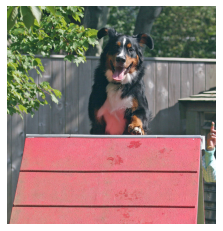

black and white dog is running on the grass


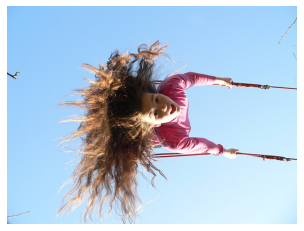

girl is leaving in the swing of the trees


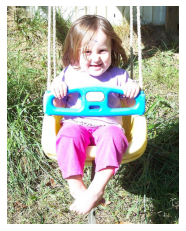

little boy in red shirt is sitting on red swing


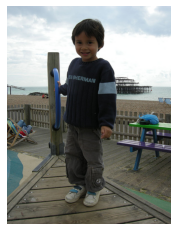

man sits on bench with his dog on lounge bench


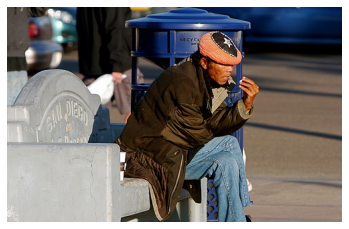

man in blue shirt and helmet sits on his back


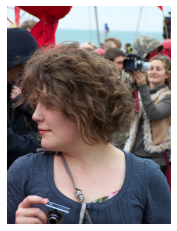

man in blue shirt and tie is sitting on the lap


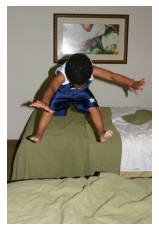

young boy in red shirt is climbing up in the air


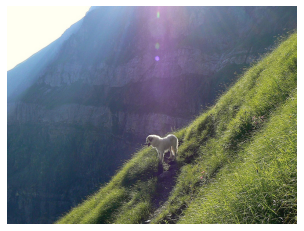

man in red shirt is rock climbing


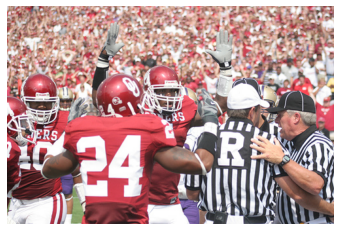

football game is preparing shot


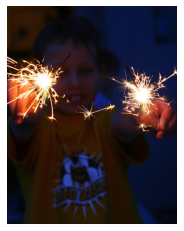

young boy in blue shirt is laying on her hand in front of wall


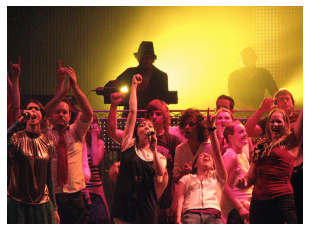

group of people are standing in line


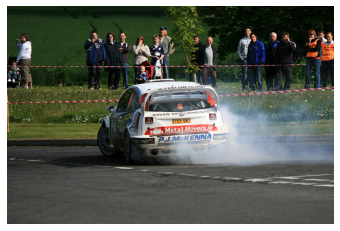

two people are riding on dirt road


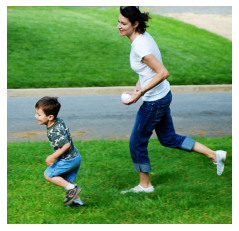

two men in white are playing with ball


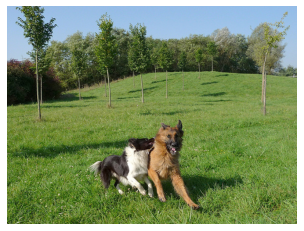

black and white dog is running on the grass


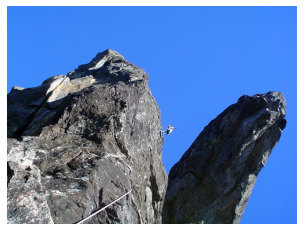

two people climbing up mountain


In [27]:
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoded_test_data.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoded_test_data[img_name].reshape((1,2048))
    
    i = plt.imread("D://Deployment projects//Image Captioning//Data//Images/"+img_name+'.jpg')
    plt.imshow(i)
    plt.axis('off')
    plt.show()
    caption = predict_caption(photo_2048)
    print(caption)